In [3]:
import os
import random
import warnings

# Our numerical workhorses
import numpy as np
import scipy.stats as st

import scipy
import scipy.ndimage
import scipy.ndimage.morphology

# BE/Bi 103 utilities
import sys
sys.path.insert(0, '/Users/Rusty/Desktop/bebi103_utils')
sys.path.append ('/Users/seinchin/Documents/Caltech/Bi 103/bebi103_utils')

import bebi103

# Image processing tools
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Applications/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1 A

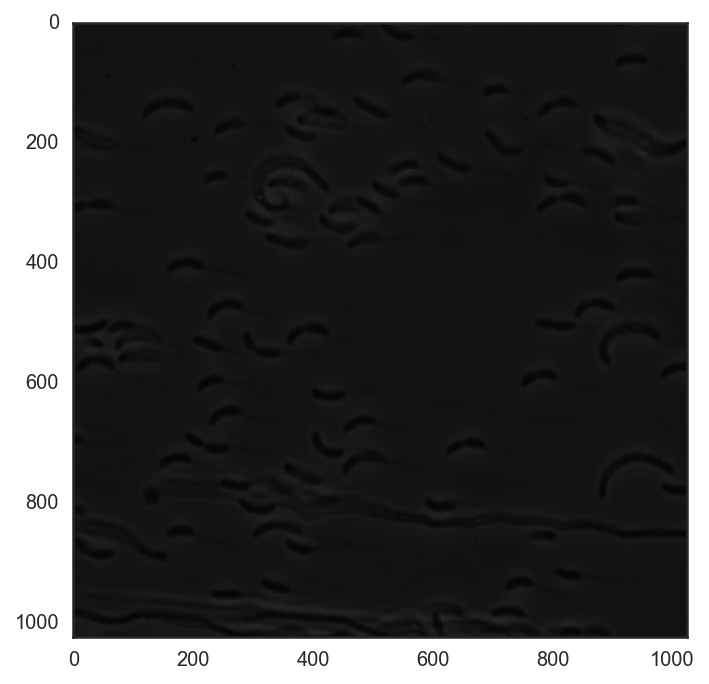

In [6]:
data_dir = 'data/hw8_iyer-biswas_et_al/sequential_full_field/'

# Define file name
fname = os.path.join(data_dir, 'phase03000.tif')

# Load the image
im = skimage.io.imread(fname)

# Take a look
with sns.axes_style('white'):
    skimage.io.imshow(im)

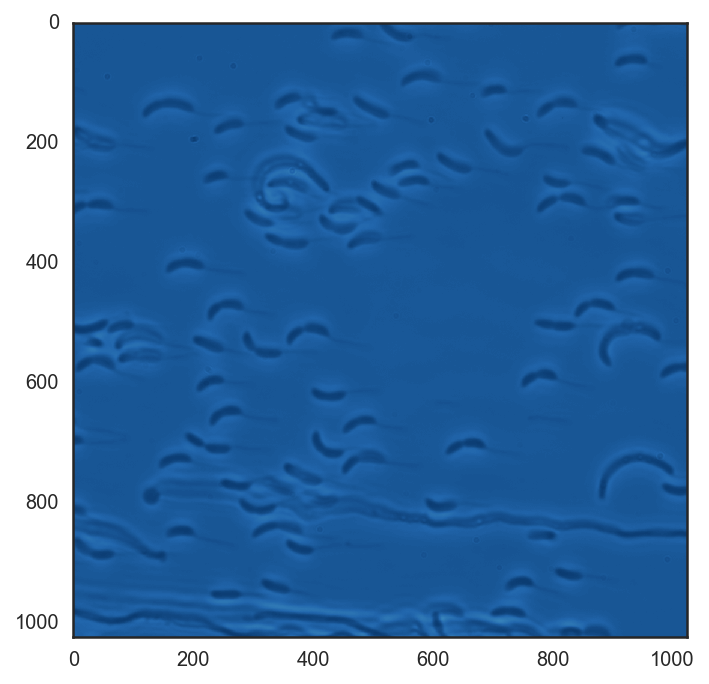

In [7]:
# This just looks black to me.  I'll try another color scheme
with sns.axes_style('white'):
    skimage.io.imshow(im, cmap=plt.cm.RdBu_r)


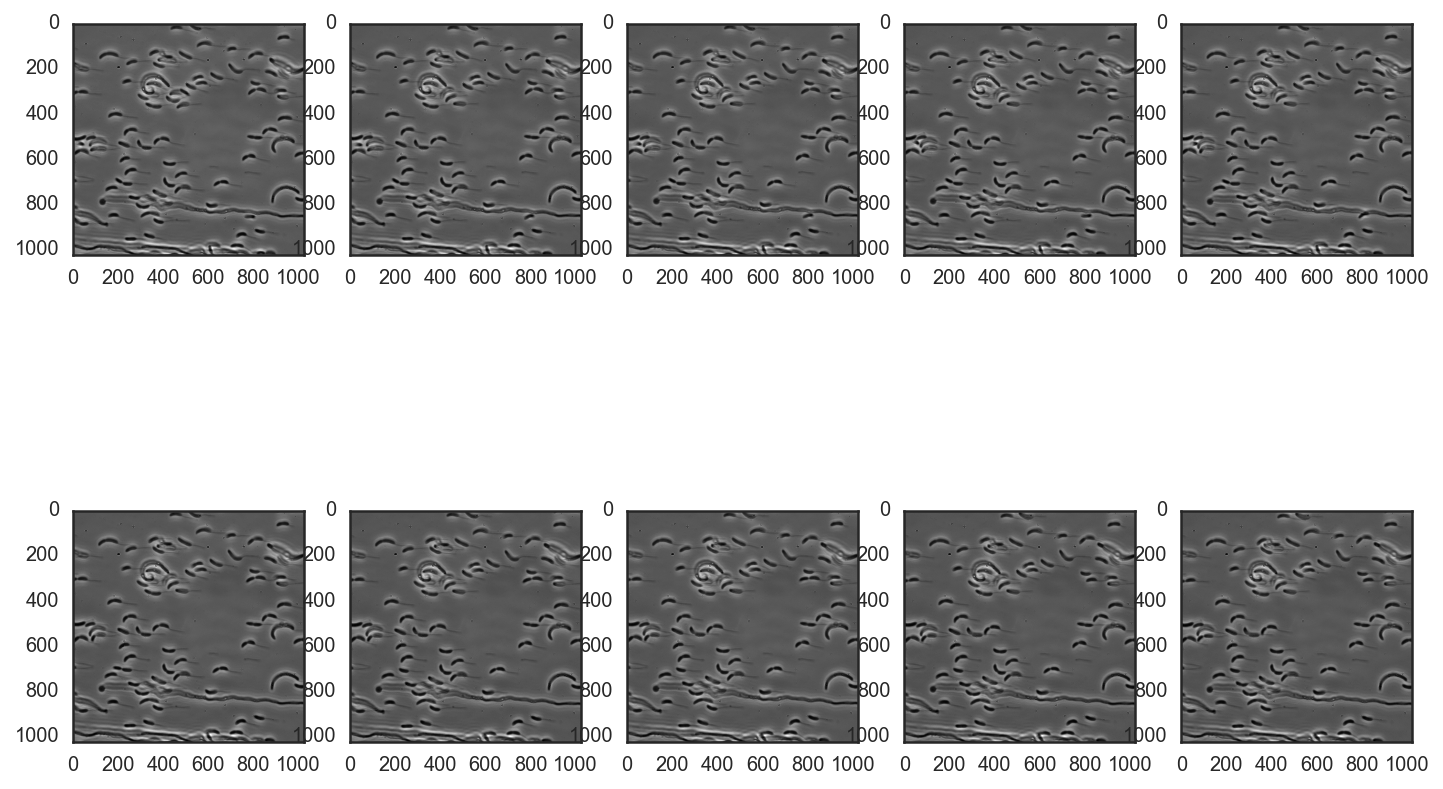

In [8]:
# Load all 10 images

fname_0 = os.path.join(data_dir, 'phase03000.tif')
fname_1 = os.path.join(data_dir, 'phase03001.tif')
fname_2 = os.path.join(data_dir, 'phase03002.tif')
fname_3 = os.path.join(data_dir, 'phase03003.tif')
fname_4 = os.path.join(data_dir, 'phase03004.tif')
fname_5 = os.path.join(data_dir, 'phase03005.tif')
fname_6 = os.path.join(data_dir, 'phase03006.tif')
fname_7 = os.path.join(data_dir, 'phase03007.tif')
fname_8 = os.path.join(data_dir, 'phase03008.tif')
fname_9 = os.path.join(data_dir, 'phase03009.tif')

ims = [skimage.io.imread(fname_0),
       skimage.io.imread(fname_1),
       skimage.io.imread(fname_2),
       skimage.io.imread(fname_3),
       skimage.io.imread(fname_4),
       skimage.io.imread(fname_5),
       skimage.io.imread(fname_6),
       skimage.io.imread(fname_7),
       skimage.io.imread(fname_8),
       skimage.io.imread(fname_9)]

# Say which images go in which subplots
im_sp = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

# Display images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 5, figsize=(12, 8))
    for i in range(10):
        ax[im_sp[i]].imshow(ims[i], cmap=plt.cm.gray)


       


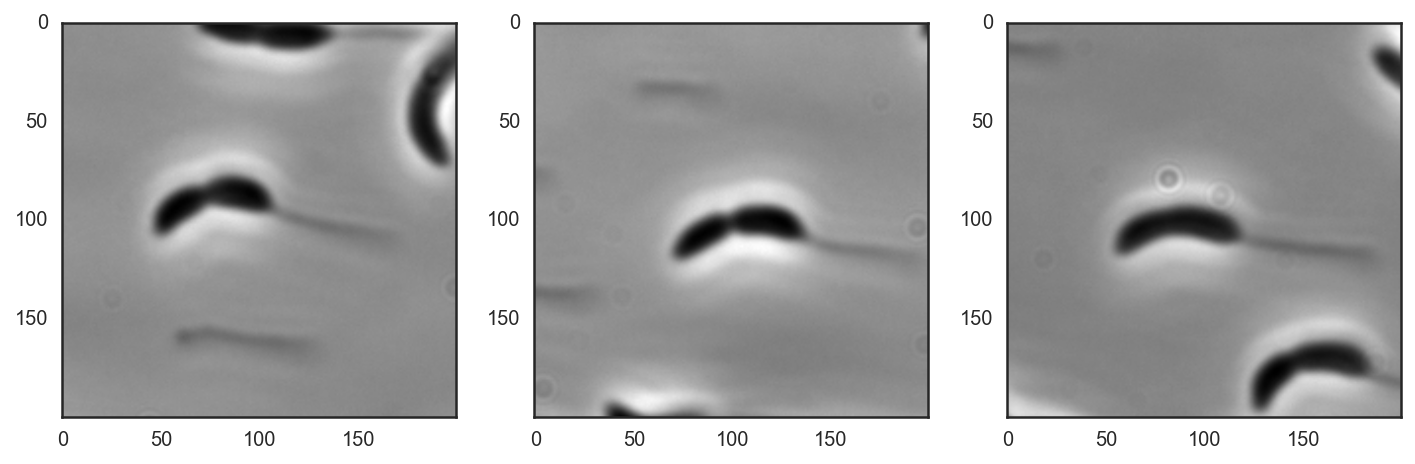

In [9]:
# Bacteria do not change position substantially in these pictures, 
# so it's ok to choose bacteria to segment based on just one picture.
# For easy segmentation, we should choose bacteria that are separated from the others
# and not near the crap at the bottom of the image

# Here are three good cantidates

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(12,5))
    ax[0].imshow(im[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im[300:500, 100:300], cmap=plt.cm.gray)


/Applications/anaconda3/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


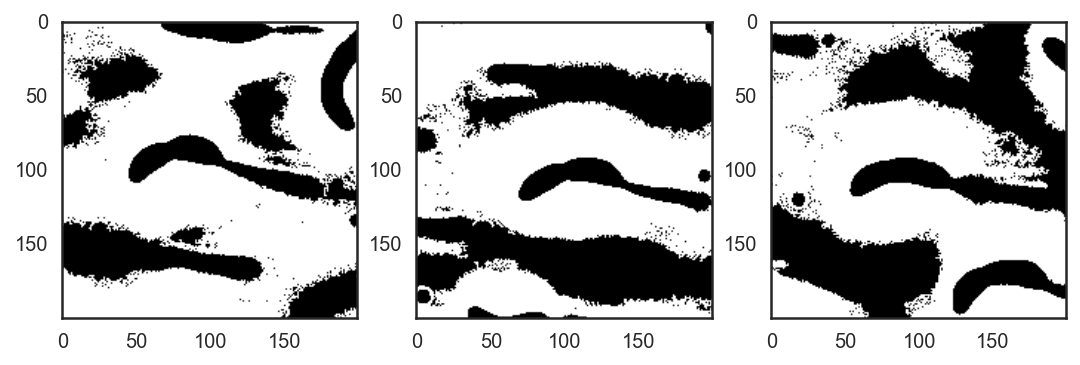

In [10]:
# Thresholding segmentation

def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """
    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filters.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

# Make the structuring element 50 pixel radius disk
selem = skimage.morphology.disk(50)

# Threshhold based on mean filter
im_bw, k = bebi103_thresh(im, selem, white_true=True, min_size=400)

# Show image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(9,5))
    ax[0].imshow(im_bw[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im_bw[300:500, 100:300], cmap=plt.cm.gray)

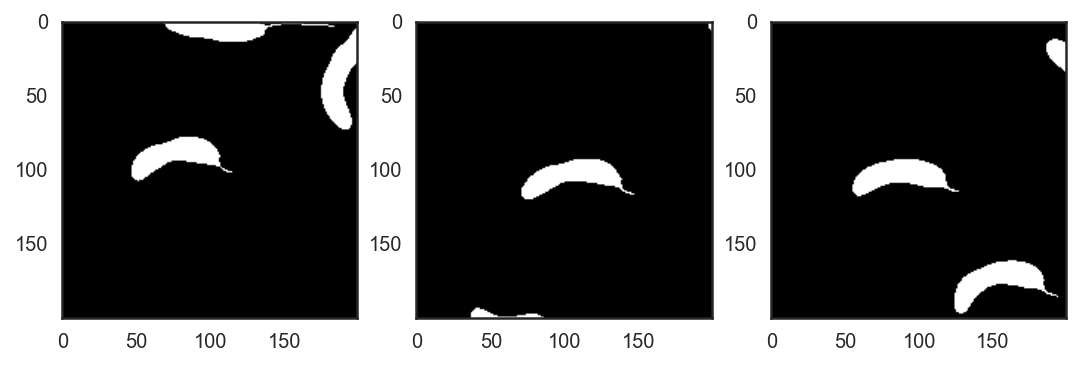

In [11]:
# That's pretty ugly, but you can see the bacteria
# Let's try Canny Edge Detection

im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
im_edge = skimage.feature.canny(im_float, 2)

selem = skimage.morphology.disk(5)
im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 3, figsize=(9,5))
    ax[0].imshow(im_bw[500:700, 700:900], cmap=plt.cm.gray)
    ax[1].imshow(im_bw[600:800, 550:750], cmap=plt.cm.gray)
    ax[2].imshow(im_bw[300:500, 100:300], cmap=plt.cm.gray)

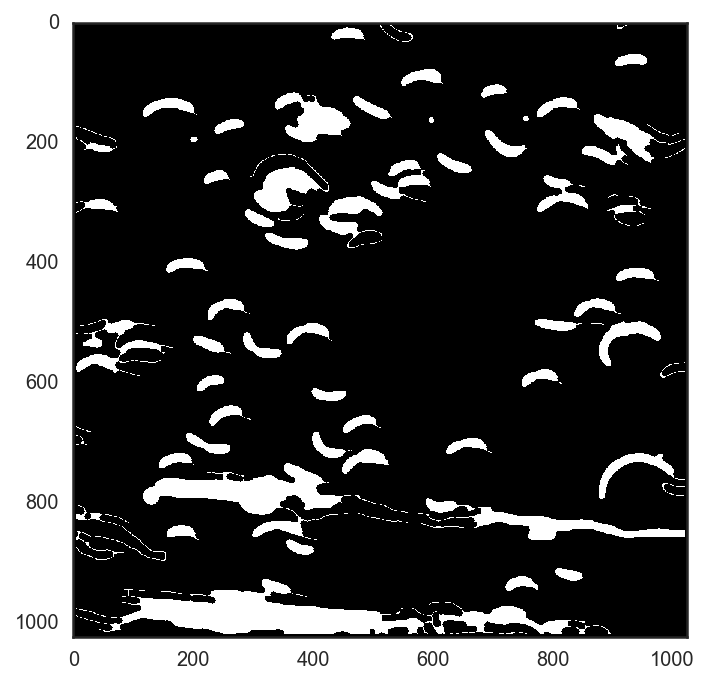

In [12]:
# Looks awesome for these bacteria
# Does the whole image look good, or, did we just choose easy bacteria?

with sns.axes_style('white'):
    skimage.io.imshow(im_bw, cmap=plt.cm.gray)

Nope, the whole image doesn't look pretty.  As I predicted, bacteria that are close to each other, and bacteria near the crap at the bottom of the image were harder to segment, but the three bacteria I chose look awesome.

# 1 B

In [13]:
data_dir = 'data/hw8_iyer-biswas_et_al/'

# Define file name
bac1 = os.path.join(data_dir, 'bacterium_1.tif')
bac2 = os.path.join(data_dir, 'bacterium_2.tif')

im_bac1 = skimage.io.imread(bac1)
im_bac2 = skimage.io.imread(bac2)

print(im_bac1.shape, im_bac2.shape)

(1900, 100, 150) (8700, 100, 300)


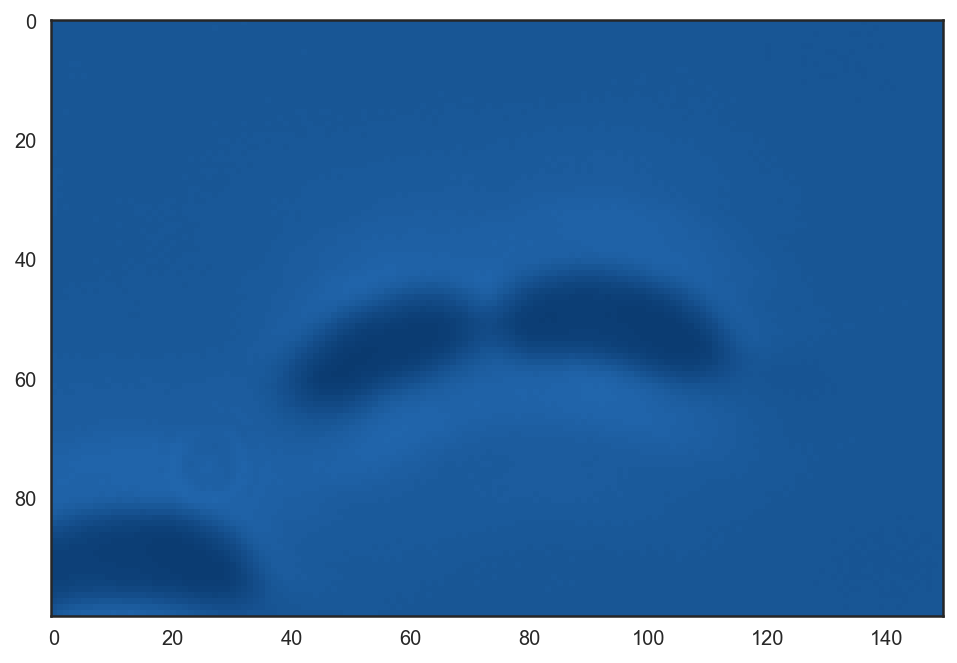

In [14]:
# There are 1900 images for Bac 1 and 8700 for Bac 2

im_bac1_0 = im_bac1[0,:,:]

with sns.axes_style('white'):
    skimage.io.imshow(im_bac1_0, cmap=plt.cm.RdBu_r)

In [17]:
# Bac1
g = 1900
bac1_bw = np.empty_like(im_bac1)

for p in range(g):
    im = im_bac1[p,:,:]
    im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
    im_edge = skimage.feature.canny(im_float, 2)

    selem = skimage.morphology.disk(4)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    
    bac1_bw[p,:,:] = im_bw



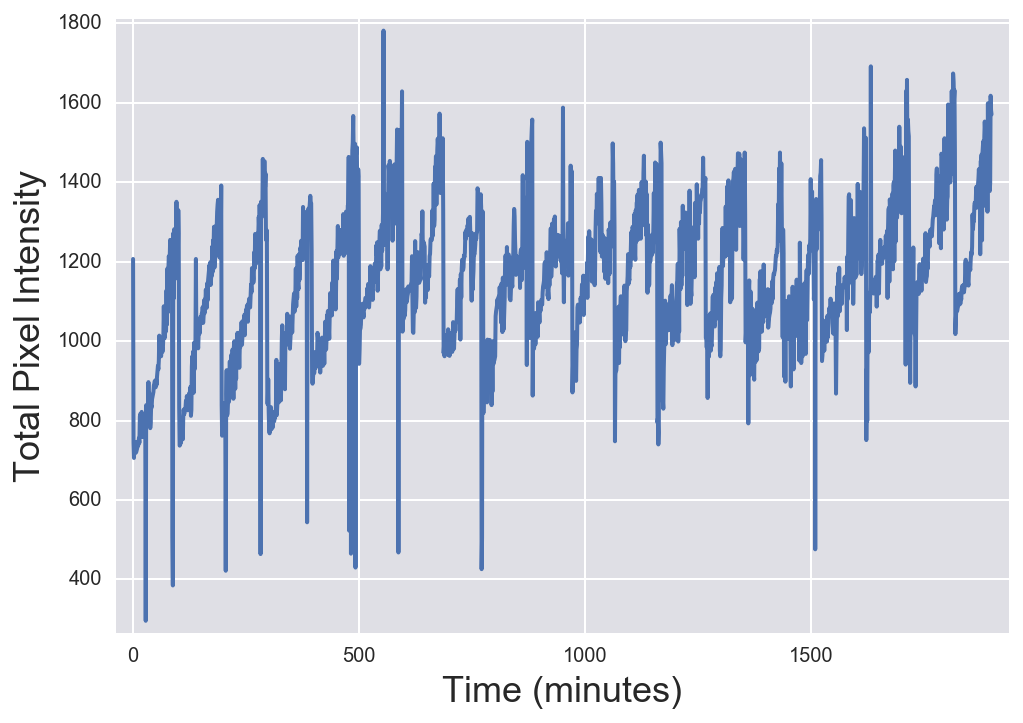

In [18]:
bac1_int = np.zeros(g)
for p in range(g):
    bac1_int[p] = bac1_bw[p,:,:].sum()

t = np.linspace(0,1900,num=1900)

plt.plot(t, bac1_int)
plt.xlabel('Time (minutes)')
plt.ylabel('Total Pixel Intensity')
plt.margins(0.02)

I count 20 periods of growth, follwed by division.  
Over 1900 minutes, that means the approximate time between divisions is 95 minutes


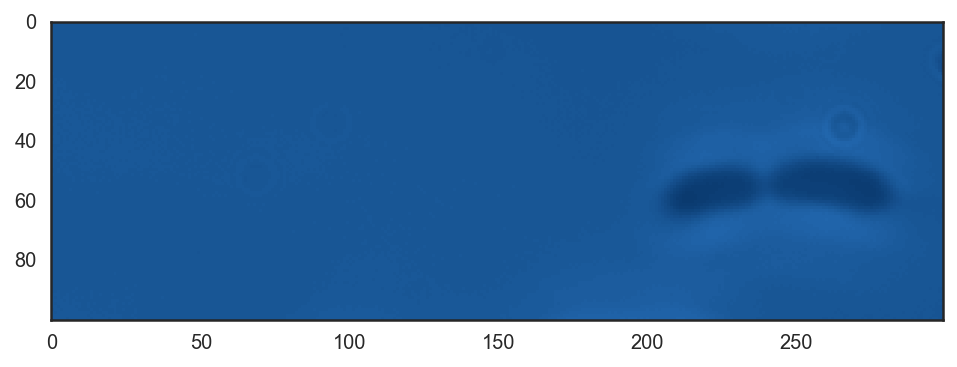

In [53]:
# Bac 2
im_bac2_0 = im_bac2[0,:,:]

with sns.axes_style('white'):
    skimage.io.imshow(im_bac2_0, cmap=plt.cm.RdBu_r)

In [ ]:
# Bac2
q = 8700
bac2_bw = np.empty_like(im_bac2)

for p in range(q):
    im = im_bac2[p,:,:]
    im_float = ((im.astype(float) - im.min()) / (im.max() - im.min()))
    im_edge = skimage.feature.canny(im_float, 1)

    selem = skimage.morphology.disk(10)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    
    bac2_bw[p,:,:] = im_bw


#with sns.axes_style('white'):
#    skimage.io.imshow(bac2_bw[0,:,:], cmap=plt.cm.gray)
    
# bac2_int = np.zeros(q)
# for p in range(q):
#     bac2_int[p] = bac2_bw[p,:,:].sum()

# t = np.linspace(0,q,num=q)

# plt.plot(t, bac2_int)
# plt.xlabel('Time (minutes)')
# plt.ylabel('Total Pixel Intensity')
# plt.margins(0.02)

## Prob 8.1c. Model selection

Let's begin by using skimage.measure.regioprops to get the cell areas. We also want to make sure there's never more than one cell in the frame, which we can do by making sure the regionprop objects are all of length one. 

In [ ]:
import skimage.measure
props = [skimage.measure.regionprops(bac1_bw[i,:,:]) for i in range(g)]
ncells = [len(p) for p in props]
area1 = [p[0].area for p in props]
print ((np.array(ncells)==1).all())
props = [skimage.measure.regionprops(bac2_bw[i,:,:]) for i in range(q)]
ncells = [len(p) for p in props]
area2 = [p[0].area for p in props]
print ((np.array(ncells)==1).all())

True